In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# paths for dataset
data_path = r"D:\machine learning tutorials\dl_project\gesture_recognition\HandGesture\images"


In [3]:
Name=[]
for file in os.listdir(data_path):
    if file[-4:]!='pt.m' and file[-4:]!='.txt':
        Name+=[file]
print(Name)
print(len(Name))

['call_me', 'fingers_crossed', 'okay', 'paper', 'peace', 'rock', 'rock_on', 'scissor', 'thumbs', 'up']
10


In [4]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]
    

In [5]:
File=[]
for file in os.listdir(data_path):
    File+=[file]
    print(file)

call_me
fingers_crossed
okay
paper
peace
rock
rock_on
scissor
thumbs
up


In [6]:
dataset=[]
testset=[]
count=0
for file in File:
    path=os.path.join(data_path,file)
    t=0
    for im in os.listdir(path):
        if im[-4:]!='pt.m' and im[-4:]!='.txt':
            image=load_img(os.path.join(path,im), color_mode='rgb', target_size=(60,60))
            image=img_to_array(image)
            image=image/255.0
            if t<400:
                dataset.append([image,count])
            else:   
                testset.append([image,count])
            t+=1
    count=count+1

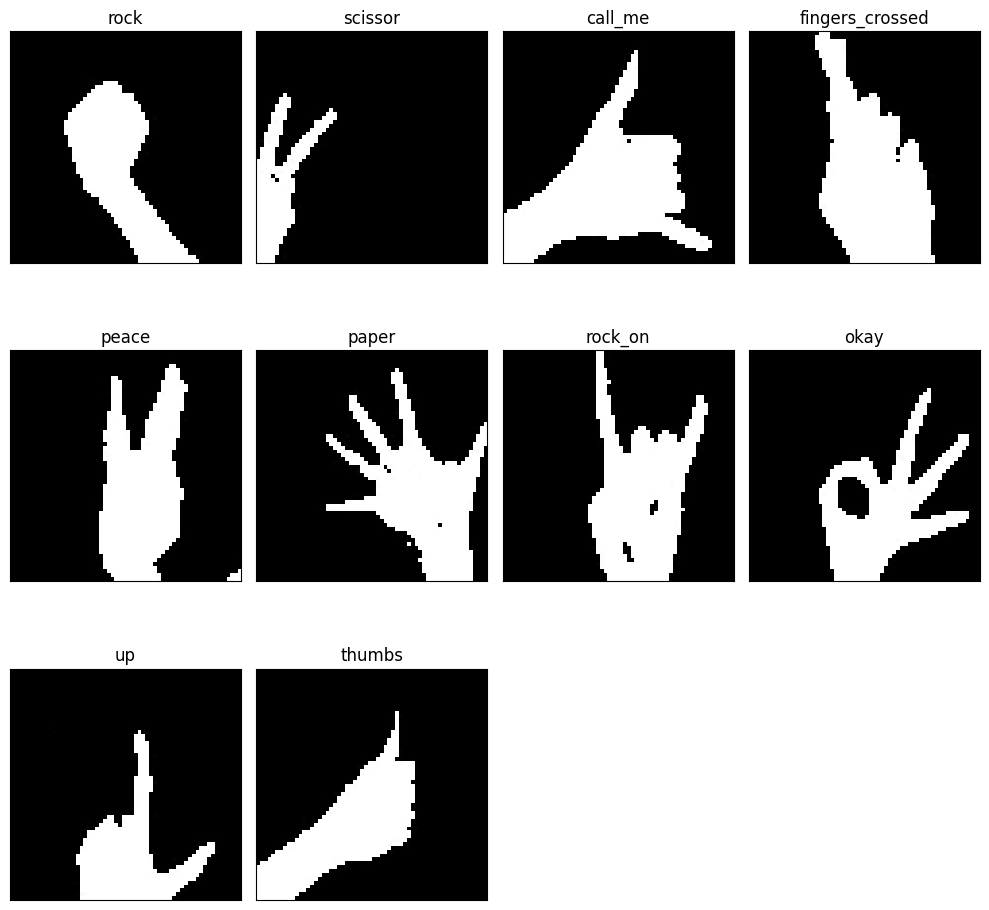

In [7]:
plt.figure(figsize=(10, 10))
for i, category in enumerate(set(reverse_mapping.values())):
    plt.subplot(3, 4, i+1)
    category_images = [img for img, lbl in dataset if reverse_mapping[lbl] == category]
    if category_images:
        plt.imshow(category_images[0], cmap='hot')
        plt.xticks([])
        plt.yticks([])
        plt.title(category)
plt.tight_layout()
plt.show()

In [8]:
data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

In [9]:
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

In [10]:
tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

In [11]:
X_train,X_test,y_train,y_test =train_test_split(data,labels,test_size=0.2,random_state=44)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 60, 60, 3)
(800, 60, 60, 3)
(3200, 10)
(800, 10)


In [12]:
import tensorflow as tf

# Step 1: Define the CNN Model for feature extraction
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),  # Flatten to prepare for RNN input
])

# Step 2: Define the RNN + LSTM Model for sequential processing
rnn_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(11, 704)),  # Input shape should match CNN output
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Step 3: Combine CNN and RNN/LSTM in the final model
# Pass data through CNN, then reshape and pass through RNN/LSTM
inputs = tf.keras.Input(shape=(60, 60, 3))
cnn_output = cnn_model(inputs)
reshaped_output = tf.keras.layers.Reshape((11, 704))(cnn_output)  # Adjust reshape dimensions
rnn_lstm_output = rnn_lstm_model(reshaped_output)

# Define the full model
model = tf.keras.Model(inputs=inputs, outputs=rnn_lstm_output)

model.summary()


d:\ProgramFiles\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 60, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 7744)           │        56,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 11, 704)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │        64,394 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,714 (471.54 KB)

 Trainable params: 120,714 (471.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2318 - loss: 2.1500 - val_accuracy: 0.6525 - val_loss: 1.0088
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7892 - loss: 0.6981 - val_accuracy: 0.8800 - val_loss: 0.3561
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9210 - loss: 0.2892 - val_accuracy: 0.9225 - val_loss: 0.2429
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9502 - loss: 0.1684 - val_accuracy: 0.9538 - val_loss: 0.1573
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9478 - loss: 0.1619 - val_accuracy: 0.9600 - val_loss: 0.1291
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9808 - loss: 0.0784 - val_accuracy: 0.9800 - val_loss: 0.0988
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9829 - loss: 0.0695 - val_accuracy: 0.9812 - val_loss: 0.0747
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9971 - loss: 0.0220 - val_accu

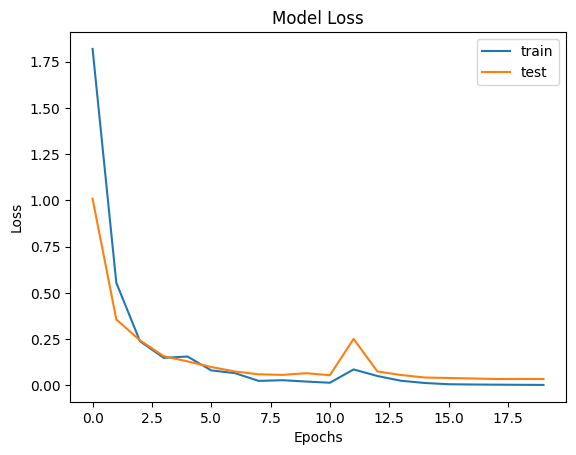

In [14]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

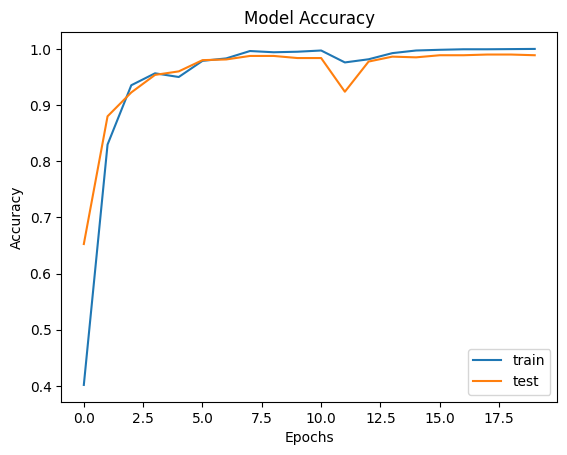

In [15]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [16]:
#calculate loss and accuracy on test data

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9910 - loss: 0.0209
Test accuracy: 98.87%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

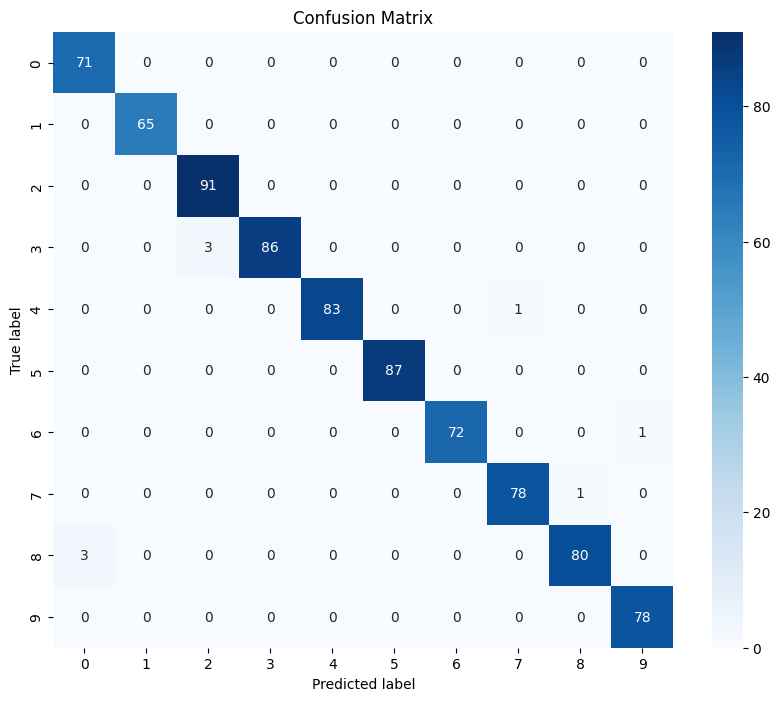

                 precision    recall  f1-score   support

        call_me       0.96      1.00      0.98        71
fingers_crossed       1.00      1.00      1.00        65
           okay       0.97      1.00      0.98        91
          paper       1.00      0.97      0.98        89
          peace       1.00      0.99      0.99        84
           rock       1.00      1.00      1.00        87
        rock_on       1.00      0.99      0.99        73
        scissor       0.99      0.99      0.99        79
         thumbs       0.99      0.96      0.98        83
             up       0.99      1.00      0.99        78

       accuracy                           0.99       800
      macro avg       0.99      0.99      0.99       800
   weighted avg       0.99      0.99      0.99       800

Overall F1 Score (Macro-average): 0.9890


In [17]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

# Ensure the model is in evaluation mode if using PyTorch or similar frameworks
# model.eval()

# Measure latency and get predictions
y_pred_classes = []
total_time = 0

for i in range(len(X_test)):
    start_time = time.time()
    
    # Model prediction
    y_pred = model.predict(np.expand_dims(X_test[i], axis=0))  # Adjust based on your framework
    y_pred_class = np.argmax(y_pred, axis=1).item()  # Adjust as needed for your model's output format
    y_pred_classes.append(y_pred_class)
    
    end_time = time.time()
    total_time += (end_time - start_time)

# Calculate average latency per prediction
average_latency = total_time / len(X_test)
print(f"Average Latency per Inference: {average_latency:.4f} seconds")

# Convert y_test to class labels if it's one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=list(reverse_mapping.values())))

# F1 score calculation (macro-average)
f1 = f1_score(y_true, y_pred_classes, average="macro")
print(f"Overall F1 Score (Macro-average): {f1:.4f}")


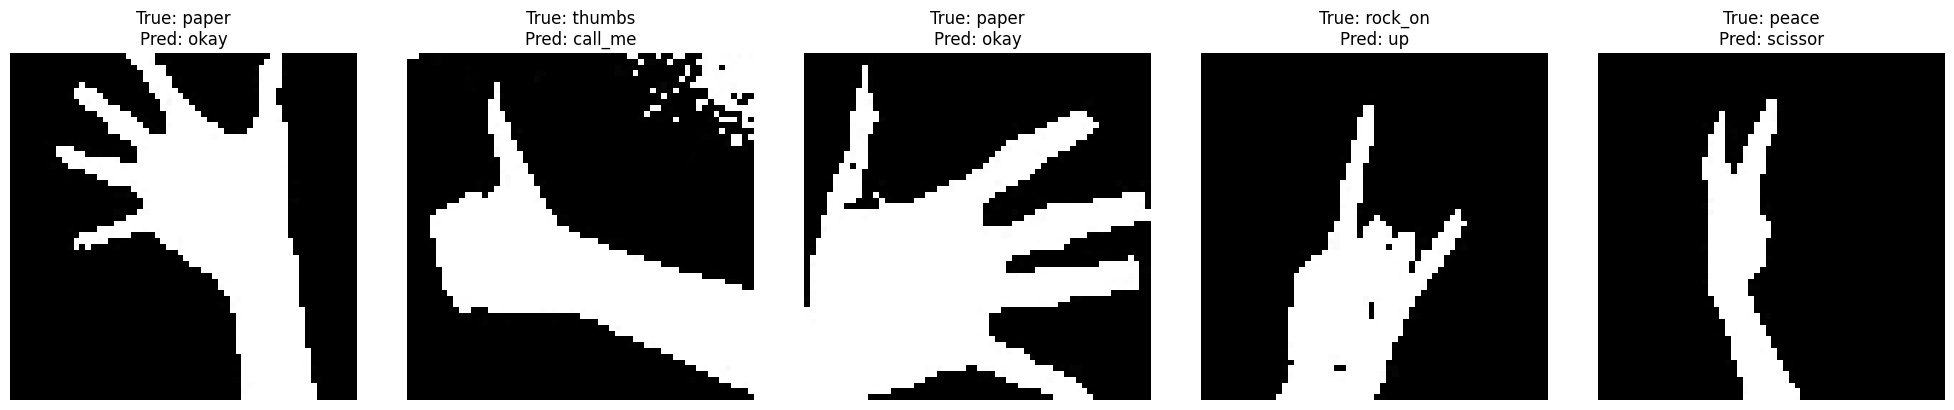

In [18]:
misclassified_indices = np.where(y_pred_classes != y_true)[0]
plt.figure(figsize=(20, 4))
for i, idx in enumerate(misclassified_indices[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].reshape(60, 60, 3))
    plt.title(f"True: {mapper(y_true[idx])}\nPred: {mapper(y_pred_classes[idx])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Original class: scissor
Predicted class: scissor
Confidence: 1.00


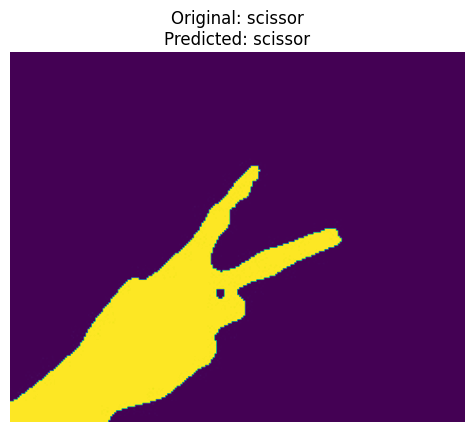

In [19]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os

def predict_image(image_path, model, mapper):
    # Open the image using PIL
    img = Image.open(image_path)
    
    # Resize the image to match the input size of our model (60x60)
    img = img.resize((60, 60))
    
    # Convert the image to a numpy array and normalize
    img_array = np.array(img) / 255.0
    
    # Add a batch dimension and channel dimension
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.expand_dims(img_array, axis=-1)
    
    # Repeat the single channel to create 3 channels
    img_array = np.repeat(img_array, 3, axis=-1)
    
    # Convert to TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    
    # Make prediction
    prediction = model(img_tensor, training=False)
    predicted_class = tf.argmax(prediction, axis=1)[0]
    
    # Get the class name
    predicted_label = mapper(predicted_class.numpy())
    
    return predicted_label, prediction[0][predicted_class].numpy()


image_path = r'D:\machine learning tutorials\dl_project\gesture_recognition\HandGesture\images\scissor\344.jpg'
predicted_label, confidence = predict_image(image_path, model, mapper)

# Get the original class from the image path
original_class = os.path.basename(os.path.dirname(image_path))

print(f"Original class: {original_class}")
print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence:.2f}")

# Optionally, display the image
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Original: {original_class}\nPredicted: {predicted_label}")
plt.axis('off')
plt.show()


Original class: up
Predicted class: up
Confidence: 1.00


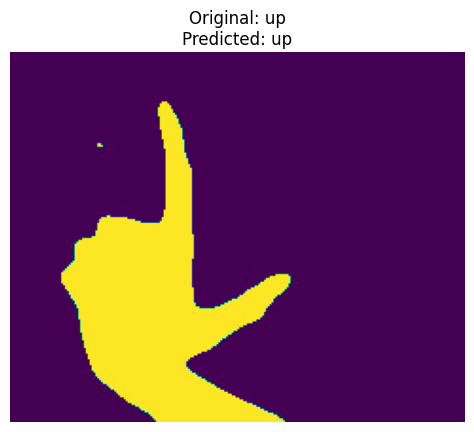

In [20]:
image_path = r'D:\machine learning tutorials\dl_project\gesture_recognition\HandGesture\images\up\10306.jpg'  # Replace with the path to your image
predicted_label, confidence = predict_image(image_path, model, mapper)

# Get the original class from the image path
original_class = os.path.basename(os.path.dirname(image_path))

print(f"Original class: {original_class}")
print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence:.2f}")

# Optionally, display the image
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Original: {original_class}\nPredicted: {predicted_label}")
plt.axis('off')
plt.show()